## Geographical data


/home/david/miniconda3/envs/tau/lib/python3.11/site-packages/geopandas/geoseries.py:574: FutureWarning:

the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.

/home/david/miniconda3/envs/tau/lib/python3.11/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning:

The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.



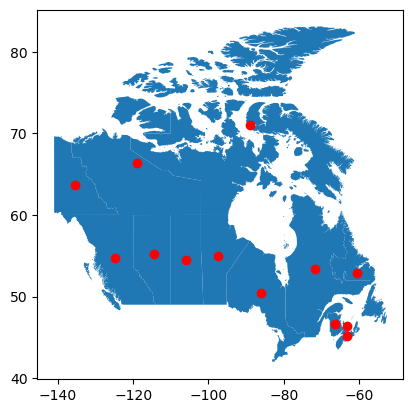

In [34]:
import geopandas as gpd

canada_gdf = gpd.read_file("data/canada/canada.geojson")
canada_gdf["centroid"]= canada_gdf["geometry"].apply(lambda x: x.centroid)
ax = canada_gdf.plot()
ax.scatter(canada_gdf["centroid"].x,canada_gdf["centroid"].y, color="red")
# this is used to get the weather data

# Batch run

In [7]:
from mesa.batchrunner import batch_run
from components.model import TechnologyAdoptionModel
from components.technologies import merge_heating_techs_with_share
import pandas as pd
from batch import (
    transform_dataframe_for_plotly,
    plotly_lines_with_error,
    transform_dict_column,
)
from batch import save_batch_parameters, read_batch_parameters, adoption_plot_with_quantiles
import plotly.graph_objects as go

heat_techs_df = merge_heating_techs_with_share()

batch_parameters = {
        "N": [200],
        "province": ["Canada"],  # , "Alberta", "Ontario"],
        "random_seed": range(20, 28),
        "start_year": [2000],
        "interact": [False],
        "n_segregation_steps": [40]
    }


results = batch_run(
    TechnologyAdoptionModel,
    batch_parameters,
    number_processes=None,
    max_steps=80,
    data_collection_period=1,
)

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:16<00:00,  2.12s/it]


In [8]:
df = pd.DataFrame(results)
print(len(df))
df[:2]

129600


RunId  iteration  Step    N province  random_seed  start_year  interact  \
0      4          0     0  200   Canada           24        2000     False   
1      4          0     0  200   Canada           24        2000     False   

   n_segregation_steps                                  Technology shares  \
0                   40  {'Electric furnace': 0.31, 'Gas furnace': 0.52...   
1                   40  {'Electric furnace': 0.31, 'Gas furnace': 0.52...   

                           Energy demand time series  AgentID  \
0  {'Electricity': [192.92854523199807, 193.32961...        0   
1  {'Electricity': [192.92854523199807, 193.32961...        1   

                                           Attitudes  Wealth  \
0  {'Electric furnace': 0.5488086320012373, 'Gas ...     0.0   
1  {'Electric furnace': -0.2973716104931923, 'Gas...     0.0   

                 Adoption details  
0  {'tech': None, 'reason': None}  
1  {'tech': None, 'reason': None}

In [9]:
adoption_detail = df[["Step","RunId","Adoption details","AgentID"]]
adoption_detail.loc[:,["tech","reason"]] = pd.DataFrame.from_records(adoption_detail["Adoption details"].values)
adoption_detail = adoption_detail.drop("Adoption details", axis=1)
adoption_detail["amount"] = 1
drop_rows = adoption_detail["tech"].apply(lambda x: x is None)
adoption_detail = adoption_detail.loc[~drop_rows,:]

adoption_detail = adoption_detail.groupby(["Step","RunId","tech","reason"]).sum().reset_index()

# get cumulative sum
adoption_detail["cumulative_amount"] = adoption_detail.groupby(["RunId","tech","reason"]).cumsum()["amount"]

# fig = px.bar(adoption_detail, x="Step", y="amount", color="tech", facet_col="RunId", facet_row="reason", template="plotly") 
fig = px.area(adoption_detail, x="Step", y="cumulative_amount", color="tech", facet_col="RunId", facet_row="reason", template="plotly") 
fig.update_yaxes(matches=None)
# fig.update_layout(width=1200)

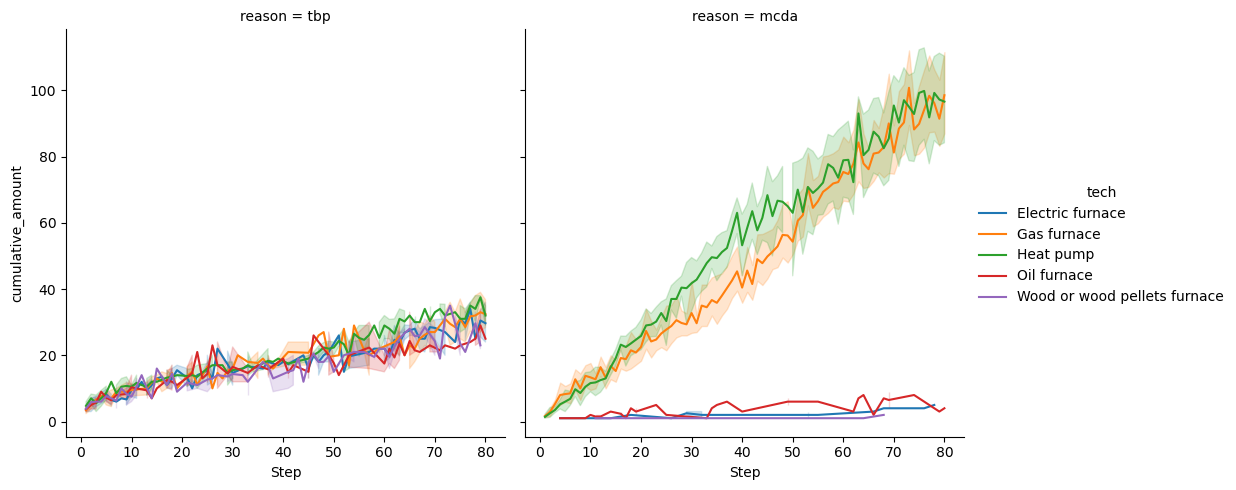

In [10]:
import seaborn as sns
sns.relplot(adoption_detail, kind="line", x="Step", y="cumulative_amount", hue="tech", col="reason")
# sns.lineplot(adoption_detail, x="Step", y="cumulative_amount", hue="tech", style="reason")

In [5]:

df_no_dict, columns = transform_dict_column(df, dict_col_name="Technology shares")
plotly_df = transform_dataframe_for_plotly(df_no_dict, columns, boundary_method="ci")


In [6]:

df2plot = df_no_dict[["RunId", "Step", *columns]].drop_duplicates()
df2plot = df2plot.melt(id_vars=["RunId", "Step"]).pivot(
    columns=["variable", "RunId"], index="Step", values="value"
)

## Visualising mutliple confidence intervals as shaded areas

In [7]:
import config
config.TECHNOLOGY_COLORS

{'Gas furnace': '#f7b799',
 'Oil furnace': '#f3d1bf',
 'Wood or wood pellets furnace': '#dde1f4',
 'Electric furnace': '#c4e8cb',
 'Heat pump': '#b0dbda'}

In [8]:

fig = adoption_plot_with_quantiles(df2plot, [0.68], mid_line="mean")
fig.update_layout(width=800)

In [15]:
import config
from matplotlib.colors import to_hex
import plotly.express as px
hex_colors = []
technology_colors = config.TECHNOLOGY_COLORS.copy()
for k,c in config.TECHNOLOGY_COLORS.items():
    c_hex = c
    # c_tuple = px.colors.unlabel_rgb(c)
    # c_tuple = [color/255 for color in c_tuple]
    # c_hex = to_hex(c_tuple)
    hex_colors.append(c_hex)
    technology_colors[k] = c_hex

technology_colors



{'Gas furnace': '#f7b799',
 'Oil furnace': '#f3d1bf',
 'Wood or wood pellets furnace': '#dde1f4',
 'Electric furnace': '#c4e8cb',
 'Heat pump': '#b0dbda'}

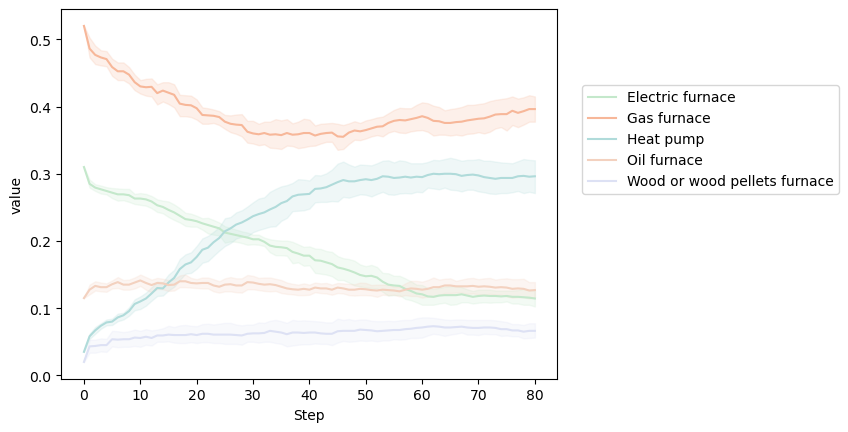

In [16]:
import seaborn as sns
df_4_plot = (
        df[["RunId", "Step", *columns]]
        .drop_duplicates()
        .melt(id_vars=["RunId", "Step"])
    )
ax = sns.lineplot(df_4_plot, x="Step", y="value", hue="variable", palette=technology_colors)
ax.legend(loc=(1.05, 0.5))

# Segregation

In [25]:

def attitude_similarity():
    att0 = model.schedule.agents[0].tech_attitudes
    att1 = model.schedule.agents[1].tech_attitudes

    df = pd.DataFrame([att0,att1])
    df += 1
    ratio = df.min()/df.max()

    return ratio.mean()

def attitude_similarity_np():
    att0 = model.schedule.agents[0].tech_attitudes
    att1 = model.schedule.agents[1].tech_attitudes

    arr = np.array([list(att0.values()),list(att1.values())])
    
    arr += 1
    
    ratio = arr.min(axis=0)/arr.max(axis=0)

    return ratio.mean()


%timeit -n 100 attitude_similarity()
%timeit -n 100 attitude_similarity_np()

763 µs ± 80.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
The slowest run took 4.36 times longer than the fastest. This could mean that an intermediate result is being cached.
41.9 µs ± 22.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [1]:
from components.model import TechnologyAdoptionModel
from components.technologies import merge_heating_techs_with_share
heating_techs = merge_heating_techs_with_share()

In [3]:
n_agents = 500
sqr_size = int(n_agents**(1/2)) + 1
n_segregation_steps = 20

model = TechnologyAdoptionModel(n_agents, sqr_size, "Ontario", heating_techs)
income_segregation_dfs = model.perform_segregation(n_segregation_steps, capture_attribute="disposable_income")

KeyboardInterrupt: 

(<Axes: >, (32, 32))

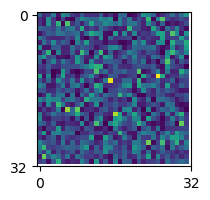

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from itertools import product

fig, ax = plt.subplots(figsize=(3,2))

img = income_segregation_dfs[-1].values
ax.imshow(img, label="income")
ax.set_yticks((0,img.shape[0]))
ax.set_xticks((0,img.shape[1]))
ax,img.shape,

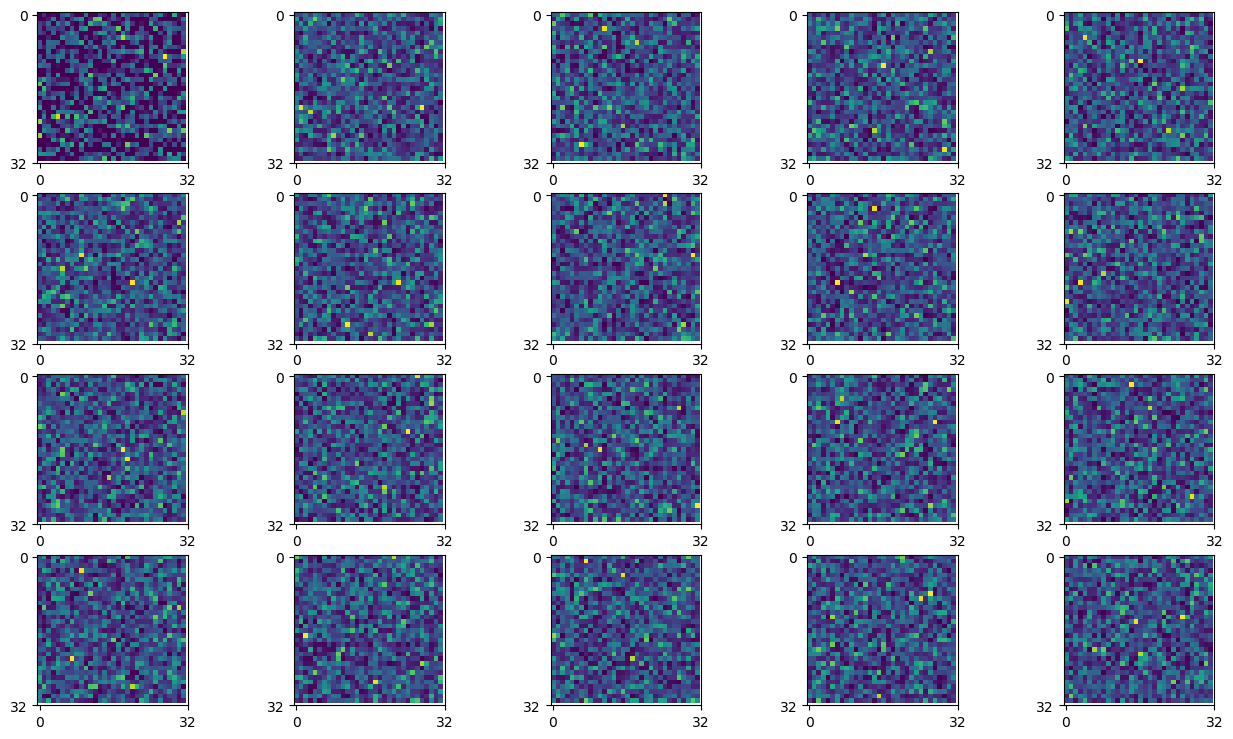

In [45]:
n_rows = int(n_segregation_steps**(1/2)) 
n_cols = n_rows +1


m_idx = list(product(range(n_rows), range(n_cols)))

fig, axes = plt.subplots(nrows=n_rows,ncols=n_cols,figsize=(16,9))

for step, income_df in enumerate(income_segregation_dfs):
    row = m_idx[step][0]
    col = m_idx[step][1]

    # values are image data
    img = income_df.values
    axes[row][col].imshow(img)

    # set ticks to only show size
    # (because the axis here, are not really relevant)
    axes[row][col].set_yticks([0,img.shape[0]])
    axes[row][col].set_xticks([0,img.shape[1]])

    # relevant_ticks = ((income_df.values.shape()))

# Parameter fit


In [26]:
from mesa.batchrunner import batch_run
from components.model import TechnologyAdoptionModel
from components.probability import beta_with_mode_at
from components.technologies import merge_heating_techs_with_share
from data.canada import nrcan_tech_shares_df

import plotly.express as px
import pandas as pd
import numpy as np
from batch import (
    transform_dataframe_for_plotly,
    plotly_lines_with_error,
    transform_dict_column,
    save_batch_parameters,
    read_batch_parameters,
    adoption_plot_with_quantiles,
)
import plotly.graph_objects as go
import seaborn as sns

province = "Canada"
start_year = 2000

heat_techs_df = merge_heating_techs_with_share(start_year=start_year, province=province)
historic_tech_shares = nrcan_tech_shares_df.copy()
historic_tech_shares.index = historic_tech_shares.index.swaplevel()
h_tech_shares = historic_tech_shares.loc[province,:]/100


n_steps = 80
def comparison_plot(mean_df):
    historic_tech_shares = nrcan_tech_shares_df.copy()
    historic_tech_shares.index = historic_tech_shares.index.swaplevel()
    h_tech_shares = historic_tech_shares.loc[province,:]/100

    h_tech_shares_long = h_tech_shares.melt(ignore_index=False)
    h_tech_shares_long["comparison"] = "historic"

    mean_df.long = mean_df.melt(ignore_index=False)
    mean_df.long["comparison"] = "modelled"

    comp_df = pd.concat([h_tech_shares_long,mean_df.long])
    ax = sns.lineplot(comp_df.reset_index(),x="index",hue="variable", y="value", style="comparison")
    ax.legend(loc=(1,.25))
    return ax.get_figure()

def get_adoption_details_from_batch_results(model_vars_df):
    adoption_detail = model_vars_df[["Step","RunId","Adoption details","AgentID"]]
    adoption_detail.loc[:,["tech","reason"]] = pd.DataFrame.from_records(adoption_detail["Adoption details"].values)
    adoption_detail = adoption_detail.drop("Adoption details", axis=1)
    adoption_detail["amount"] = 1
    drop_rows = adoption_detail["tech"].apply(lambda x: x is None)
    adoption_detail = adoption_detail.loc[~drop_rows,:]

    adoption_detail = adoption_detail.groupby(["Step","RunId","tech","reason"]).sum().reset_index()

    # get cumulative sum
    adoption_detail["cumulative_amount"] = adoption_detail.groupby(["RunId","tech","reason"]).cumsum()["amount"]
    return adoption_detail

In [27]:
techs = heat_techs_df.index.to_list()
tech_mode_map = dict(zip(techs,[0.5]*len(techs)))

batch_parameters = {
    "N": [150],
    "grid_side_length": [15],
    "heating_techs_df": [heat_techs_df],
    "province": [province],  # , "Alberta", "Ontario"],
    "random_seed": range(20, 28),
    "start_year": start_year,
    "tech_attitude_dist_func":[beta_with_mode_at], 
    "tech_attitude_dist_params":[tech_mode_map],
    "n_segregation_steps" : [30],
    "interact" : [True],
}

adoption_share_dfs = []
adoption_detail_dfs = []

mode_shift = 0.15
best_abs_diff = 1e12
greatest_diff_sum = None
for i in range(7):
    results = batch_run(
        TechnologyAdoptionModel,
        batch_parameters,
        number_processes=None,
        max_steps=80,
        data_collection_period=1,
    )
    df = pd.DataFrame(results)
    df_no_dict, columns = transform_dict_column(df, dict_col_name="Technology shares")
    df2plot = df_no_dict[["RunId", "Step", *columns]].drop_duplicates()
    df2plot = df2plot.melt(id_vars=["RunId", "Step"]).pivot(
        columns=["variable", "RunId"], index="Step", values="value"
    )
    
    adoption_detail_dfs.append(get_adoption_details_from_batch_results(df))

    mean_df = pd.DataFrame()
    for col in df2plot.columns.get_level_values(0).unique():
        mean_df.loc[:,col] = df2plot[col].mean(axis=1)

    mean_df.index = TechnologyAdoptionModel.steps_to_years_static(batch_parameters["start_year"],range(81),1/4)
    diff_sum = (h_tech_shares-mean_df).sum()
    
    current_abs_diff = diff_sum.abs().sum()
    print(i,current_abs_diff)
    
    if greatest_diff_sum is not None:
        if diff_sum.abs().sum() > greatest_diff_sum.abs().sum():
            greatest_diff_sum = diff_sum.copy()
    else:
        greatest_diff_sum = diff_sum.copy()


    if best_abs_diff < current_abs_diff:
        print("Performance degradation. Scaling down mode_shift")
        mode_shift = mode_shift/2
        att_update = att_update/2
        tech_mode_map = best_modes.to_dict()
    else:
        best_abs_diff = current_abs_diff
        if "new_modes" in locals():
            best_modes = new_modes.copy()
        att_update = diff_sum/greatest_diff_sum.abs().max()*mode_shift
    new_modes = pd.Series(tech_mode_map) + att_update


    mean_df["iteration"] = i
    adoption_share_dfs.append(mean_df)

    new_modes[new_modes<=0] = 0.05
    new_modes[new_modes>=1] = 0.95
    debug_info = pd.concat([diff_sum.rename("diff_sum"),new_modes.rename("new_modes")], axis=1,)
    print(i,debug_info)
    tech_mode_map = new_modes.to_dict()
    batch_parameters["tech_attitude_dist_params"] = [tech_mode_map]

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:27<00:00,  3.42s/it]


0 7.651447371114854
0                               diff_sum  new_modes
Electric furnace              2.987060   0.636021
Gas furnace                   0.838424   0.538179
Heat pump                    -3.294042   0.350000
Oil furnace                  -0.510835   0.476738
Wood or wood pellets furnace -0.021086   0.499040


100%|██████████| 8/8 [00:27<00:00,  3.43s/it]


1 4.6574267107194
1                               diff_sum  new_modes
Electric furnace              2.304560   0.740963
Gas furnace                  -1.505743   0.469612
Heat pump                    -0.656542   0.320103
Oil furnace                  -0.166668   0.469149
Wood or wood pellets furnace  0.023914   0.500129


100%|██████████| 8/8 [00:29<00:00,  3.67s/it]


2 2.5426049305777982
2                               diff_sum  new_modes
Electric furnace              0.342060   0.756539
Gas furnace                   0.720091   0.502403
Heat pump                    -1.271542   0.262201
Oil furnace                   0.133332   0.475220
Wood or wood pellets furnace  0.075580   0.503570


100%|██████████| 8/8 [00:40<00:00,  5.10s/it]


3 1.4759382639111314
3                               diff_sum  new_modes
Electric furnace              0.308726   0.770598
Gas furnace                   0.222591   0.512539
Heat pump                    -0.738209   0.228586
Oil furnace                   0.164165   0.482696
Wood or wood pellets furnace  0.042247   0.505494


100%|██████████| 8/8 [00:40<00:00,  5.09s/it]


4 1.8568188145995979
Performance degradation. Scaling down mode_shift
4                               diff_sum  new_modes
Electric furnace             -0.181274   0.763569
Gas furnace                   0.588424   0.507471
Heat pump                    -0.747376   0.245393
Oil furnace                   0.209165   0.478958
Wood or wood pellets furnace  0.130580   0.504532


100%|██████████| 8/8 [00:34<00:00,  4.33s/it]


5 1.3442715972444648
5                               diff_sum  new_modes
Electric furnace              0.068726   0.765133
Gas furnace                   0.254257   0.513260
Heat pump                    -0.672376   0.230085
Oil furnace                   0.284998   0.485447
Wood or wood pellets furnace  0.063914   0.505988


100%|██████████| 8/8 [00:32<00:00,  4.10s/it]


6 1.2059382639111313
6                               diff_sum  new_modes
Electric furnace              0.077060   0.766888
Gas furnace                   0.212591   0.518100
Heat pump                    -0.603209   0.216350
Oil furnace                   0.197498   0.489944
Wood or wood pellets furnace  0.115580   0.508619


In [28]:
l_hist_shares = historic_tech_shares.loc[province,:].melt(ignore_index=False).reset_index()
l_hist_shares["iteration"] = "historic"
l_hist_shares["value"] *= 0.01

In [29]:
test = dict(zip("abc", [0.9,0.5,-0.7]))
test1 = dict(zip("abc",[0.8,0.0,0.7]))
atts = pd.DataFrame([test,test1])
# atts += abs(atts.min().min())
# atts /= atts.max().max()    
atts += 1
quot = (atts.min()/atts.max())
print(quot)
similarity = quot.mean()

if similarity > 1:
    similarity = 1/similarity

similarity
# abs_diff = (atts.loc[0,:]-atts.loc[1,:]).abs()
# abs_diff
# similarity = 1 - abs_diff.sum()/atts.abs().sum().sum()
# similarity

a    0.947368
b    0.666667
c    0.176471
dtype: float64


0.5968352253181975

In [30]:
def parameter_fit_results(dfs: list[pd.DataFrame]):
    results = pd.concat(dfs)
    results.reset_index(names=["year"], inplace=True)
    long_results = results.melt(id_vars=["year","iteration"])
    return long_results

pfit_res = parameter_fit_results(adoption_share_dfs)
pfit_res_historic = pd.concat( [pfit_res, l_hist_shares])

fig = px.line(pfit_res, x="year", y="value", color="variable", line_dash="iteration", template="plotly", )

def update_trace_opacity(trace: go.Trace):
    # TODO: add this variable in loop above
    n_fit_iterations = 10
    iteration = trace.name.split(",")[-1]
    if iteration == " historic":
        opacity = 1
    else:
        opacity = int(iteration) * 1/n_fit_iterations

    trace.opacity = opacity


fig.for_each_trace(lambda t: update_trace_opacity(t))

for i,tech in enumerate(historic_tech_shares.loc[province,:].columns):
    fig.add_trace(
        go.Scatter(
            x=historic_tech_shares.loc[province,tech].index,
            y=historic_tech_shares.loc[province,tech].values/100,
            mode="lines",
            name=f"{tech}, historic",
            line=dict(dash="solid", width=3, color=px.colors.qualitative.Plotly[i]),
        )
    )

fig.update_layout(width=800)

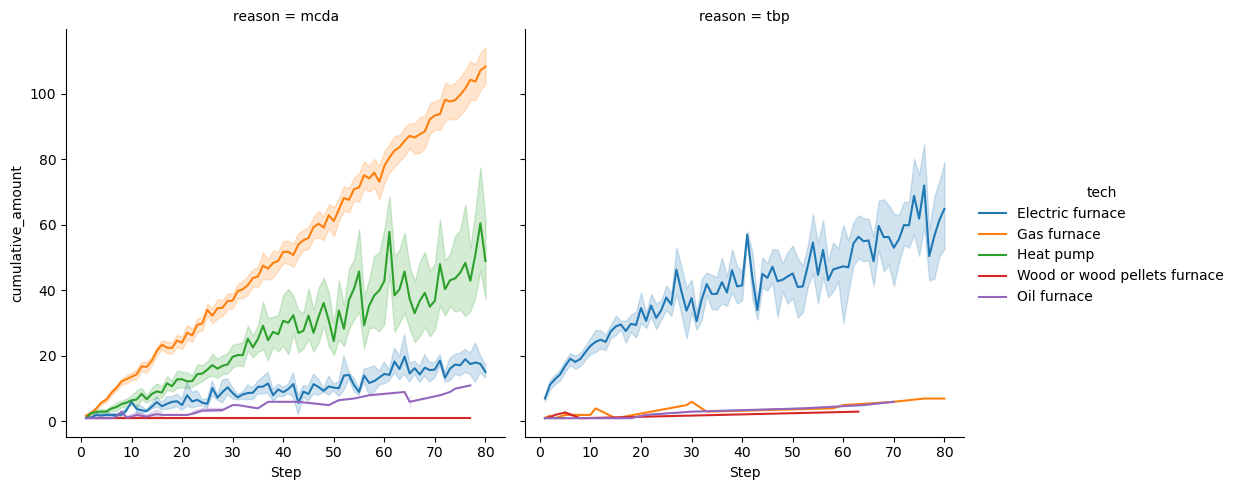

In [31]:
adoption_detail_df = pd.concat(adoption_detail_dfs)
sns.relplot(adoption_detail_df,kind="line", x="Step", y="cumulative_amount", hue="tech", col="reason")
# sns.lineplot(adoption_detail_df, x="Step", y="cumulative_amount", hue="tech")

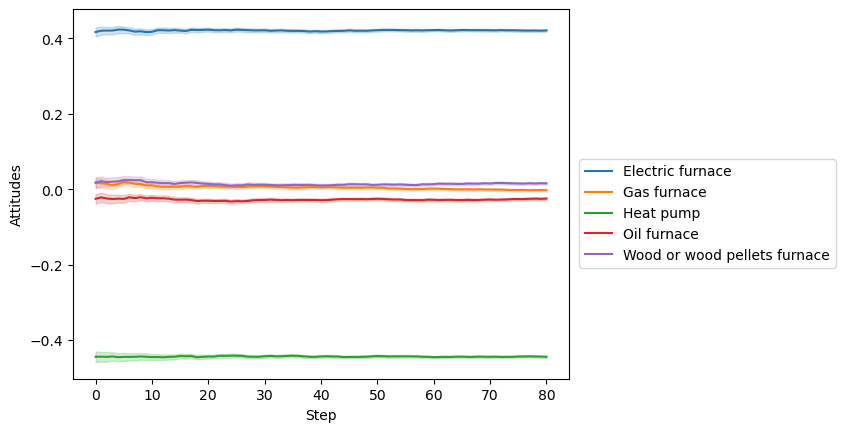

In [32]:
df = pd.DataFrame(results)
# df.head()
attitudes_df = df[["Step","AgentID","Attitudes","RunId"]]
atts = pd.DataFrame.from_records(attitudes_df["Attitudes"].values)
attitudes_df.loc[:,atts.columns] = atts
attitudes_df = attitudes_df.drop(columns=["Attitudes"])
attitudes_df_long =attitudes_df[["Step", *atts.columns]].melt(id_vars=["Step"])
ax = sns.lineplot(attitudes_df_long, x="Step", y="value", hue="variable")
ax.set_ylabel("Attitudes")
ax.legend(loc=(1.02,0.3))

## Draw dependent random parameters (mcda weights)

weights for mcda need to be diverse across agents, and have to add up to 1.
This can be achieved, by drawing one weight $w_0$ from an assumed distribution D between 0 and 1, and then drawing $w_i$ from the same distribution with adapted boundaries as $1 - w_0$ for the upper bound. More formally, the equation for the upper bound of $w_i$ is:
$$ 1- \sum_{i-1} w_{i-1} $$



In [52]:
# from scipy.stats import beta
# from scipy.optimize import curve_fit
# from ipywidgets import interact

# normed_income_freq = canada_income["VALUE"]/canada_income["VALUE"].sum()
# normed_income_bins = canada_income["Mean income"]/canada_income["Mean income"].sum()

# def fit_beta(a, b):
#     x = np.linspace(0, 1, 100)
#     y = beta.pdf(x, a, b)
#     y = y / y.max() * normed_income_freq.max()
#     ax = plt.pyplot.plot(x, y, label="beta fit")
#     plt.pyplot.plot(canada_income["Mean income"]/canada_income["Mean income"].max(),normed_income_freq)
#     return ax

# x = np.linspace(0, 1, 100)
# def scaled_beta(x, a, b):
#     y = beta.pdf(x, a, b)
#     y = y / y.max() * normed_income_freq.max() 
#     return y
    

# p,v = curve_fit(scaled_beta, normed_income_bins, normed_income_freq, p0=(2, 2))

# # interact(fit_beta, a=(0.5, 10.), b=(0.5, 10.))

# p

In [65]:
from components.model import get_income_and_attitude_weights

all_dfs = []
for p_mode in [0.5, 0.7, 0.9]:
    _, weights_df = get_income_and_attitude_weights(1000, price_weight_mode=p_mode)
    weights_df["mode"] = p_mode
    # print(weights_df.head())
    all_dfs.append(weights_df.copy())

all_df = pd.concat(all_dfs)

fig = px.histogram(
    all_df.melt(id_vars=["mode"]),
    facet_col="variable",
    facet_row="mode",
    category_orders={
        "variable": ["cost_norm", "emissions_norm", "attitude"],
        "mode": [0.5, 0.7, 0.9][::-1],
    },
)
fig.update_layout(template="plotly", xaxis_title="test", width=800)

In [66]:
_, w_df = get_income_and_attitude_weights(100)
(w_df.sum(axis=1) == 1.0).sum()

100

## parameter fit for mcda-weight's mode

In [72]:
# new_modes
# Electric furnace                0.766605
# Gas furnace                     0.504180
# Heat pump                       0.146975
# Oil furnace                     0.568051
# Wood or wood pellets furnace    0.514014

Electric furnace                0.766605
Gas furnace                     0.504180
Heat pump                       0.146975
Oil furnace                     0.568051
Wood or wood pellets furnace    0.514014
dtype: float64

In [70]:
from batch import transform_dict_column
province = "Canada"
start_year = 2000
heat_techs_df = merge_heating_techs_with_share(start_year=start_year, province=province)

batch_parameters = {
    "N": [150],
    "grid_side_length": [15],
    "heating_techs_df": [heat_techs_df],
    "province": [province],  # , "Alberta", "Ontario"],
    "random_seed": range(20, 28),
    "start_year": start_year,
    "tech_attitude_dist_func":[beta_with_mode_at], 
    "tech_attitude_dist_params":[best_modes.to_dict()],
    "n_segregation_steps": [30],
    "interact": [False],
}

adoption_dfs = []
for p_mode in [0.9, 0.8, 0.7, 0.6]:
    
    # # single model run
    # model = TechnologyAdoptionModel(100, 11, province, heat_techs_df, price_weight_mode=p_mode, tech_attitude_dist_params=new_modes.to_dict(), tech_attitude_dist_func=beta_with_mode_at)
    # for i in range(80):
    #     model.step()

    # model_vars = model.datacollector.get_model_vars_dataframe()
    # adoption_df = transform_dict_column(model_vars[["Technology shares"]], return_cols=False)
    # adoption_df.index = model.get_steps_as_years()
    # adoption_df["p_mode"] = p_mode
    # adoption_dfs.append(adoption_df)

    # diff_sum = (h_tech_shares-adoption_df).sum()    
    batch_parameters["price_weight_mode"] = p_mode

    results = batch_run(
        TechnologyAdoptionModel,
        batch_parameters,
        number_processes=None,
        max_steps=80,
        data_collection_period=1,
    )
    df = pd.DataFrame(results)
    df_no_dict, columns = transform_dict_column(df, dict_col_name="Technology shares")
    df2plot = df_no_dict[["RunId", "Step", *columns]].drop_duplicates()
    df2plot = df2plot.melt(id_vars=["RunId", "Step"]).pivot(
        columns=["variable", "RunId"], index="Step", values="value"
    )
    
    mean_df = pd.DataFrame()
    for col in df2plot.columns.get_level_values(0).unique():
        mean_df.loc[:,col] = df2plot[col].mean(axis=1)

    mean_df.index = TechnologyAdoptionModel.steps_to_years_static(batch_parameters["start_year"],range(81),1/4)
    mean_df["p_mode"] = p_mode
    adoption_dfs.append(mean_df)
    diff_sum = (h_tech_shares-mean_df).sum()

    
    total_abs_diff = diff_sum.abs().sum()
    print(p_mode,total_abs_diff)
    # print(f"finished iteration {i}")

mcda_fit_results = pd.concat(adoption_dfs)



  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:10<00:00,  1.29s/it]


0.9 1.6474236931702024


100%|██████████| 8/8 [00:10<00:00,  1.28s/it]


0.8 1.372423693170202


100%|██████████| 8/8 [00:12<00:00,  1.50s/it]


0.7 1.6092715972444651


100%|██████████| 8/8 [00:11<00:00,  1.47s/it]


0.6 2.3151521479329316


In [72]:
fit_results_long = mcda_fit_results.melt(ignore_index=False, id_vars=["p_mode"]).reset_index()
fit_results_long["value"] *= 100
fig = px.line(fit_results_long, x="index", y="value", color="variable", line_dash="p_mode", template="plotly")
for i,tech in enumerate(historic_tech_shares.loc[province,:].columns):
    fig.add_trace(
        go.Scatter(
            x=historic_tech_shares.loc[province,tech].index,
            y=historic_tech_shares.loc[province,tech].values,
            mode="lines",
            name=f"{tech}, historic",
            line=dict(dash="solid", width=3, color=px.colors.qualitative.Plotly[i]),
        )
    )
fig.update_layout(yaxis_title="Market share (%)", xaxis_title="Time", title=f"Technology shares in {province}", width=800)

legend_traces = [
    px.line(
        fit_results_long,
        x="index",
        y=np.full(len(fit_results_long), -1000),
        **param["px"],
        template="plotly"
    ).update_traces(**param["lg"], legendgroup=str(param["px"]))
    for param in [
        {"px": {"color": "variable"}, "lg": {"legendgrouptitle_text": "Heating appliance"}},
        # {"px": {"symbol": "Device"}, "lg": {"legendgrouptitle_text": "Device"}},
        {"px": {"line_dash": "p_mode"}, "lg": {"legendgrouptitle_text": "p_mode"},
        },
    ]
]
for t in legend_traces:
    fig.add_traces(t.data)
# hide the dummy traces for extra legend entries (given y-value of -1000)
fig.update_yaxes(range=[0, fit_results_long["value"].max()])

In [62]:
from data.canada import tech_capex_df
from components.technologies import is_num

capex_df = tech_capex_df#.reset_index()
keep = capex_df["Heat pump"].apply(is_num)
avg_prices = capex_df.loc[keep,:].astype(float).reset_index().groupby("variable").mean().drop("year", axis=1)


avg_prices

Electric furnace  Gas furnace  Heat pump  Oil furnace  \
variable                                                                        
efficiency                          1.00        0.900      3.000        0.900   
lifetime                           20.00       20.000     15.000       30.000   
specific_cost                      81.81      181.400    794.364      185.386   
specific_fom_cost                   3.17        3.664     14.202        5.608   
specific_fuel_emission              0.40        0.200      0.400        0.500   

                        Wood or wood pellets furnace  
variable                                              
efficiency                                     0.800  
lifetime                                      20.000  
specific_cost                                460.894  
specific_fom_cost                             26.740  
specific_fuel_emission                         0.150

In [50]:
diff_sum = (h_tech_shares-adoption_df).sum()


In [45]:
adoption_df

Electric furnace  Gas furnace  Heat pump  Oil furnace  \
0               0.31         0.52       0.04         0.11   
1               0.29         0.50       0.08         0.10   
2               0.29         0.49       0.09         0.10   
3               0.28         0.48       0.10         0.10   
4               0.28         0.47       0.10         0.11   
..               ...          ...        ...          ...   
75              0.12         0.59       0.19         0.07   
76              0.12         0.60       0.18         0.07   
77              0.12         0.60       0.18         0.07   
78              0.12         0.60       0.18         0.07   
79              0.12         0.60       0.17         0.08   

    Wood or wood pellets furnace  
0                           0.02  
1                           0.03  
2                           0.03  
3                           0.04  
4                           0.04  
..                           ...  
75                          0.03  
76                          0.03  
77                          0.03  
78                          0.03  
79                          0.03  

[80 rows x 5 columns]

# track adoption details


In [5]:
from components.technologies import merge_heating_techs_with_share
from components.model import TechnologyAdoptionModel


heating_techs_df = merge_heating_techs_with_share()
model = TechnologyAdoptionModel(
    100, 11, "Canada", heating_techs_df, start_year=2000, random_seed=123
)

for _ in range(80):
    model.step()

TypeError: TechnologyAdoptionModel.__init__() got multiple values for argument 'start_year'

In [6]:

final_df = model.get_adoption_details()
px.bar(final_df, x="step", y="value", color="tech", facet_row="reason", template='plotly')


NameError: name 'model' is not defined

In [7]:
total_adopted_appliances_count = final_df.reason.value_counts()
adoption_reason_share =total_adopted_appliances_count/total_adopted_appliances_count.sum()
adoption_reason_share

reason
mcda    0.8125
tpb     0.1875
Name: count, dtype: float64

<Axes: xlabel='tech', ylabel='age'>

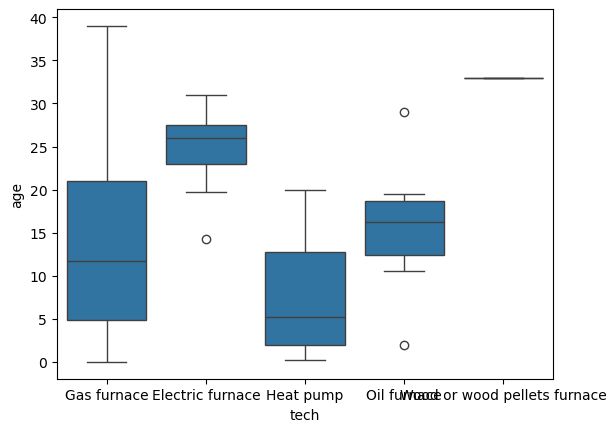

In [65]:
import seaborn as sns
techs = []
for a in model.schedule.agents:
    techs.append((a.heating_tech.name, a.heating_tech.age))

df = pd.DataFrame.from_records(techs, columns=["tech", "age"])
sns.boxplot(df, x="tech",y="age")

Text(0.5, 0, 'number of adopted appliances')

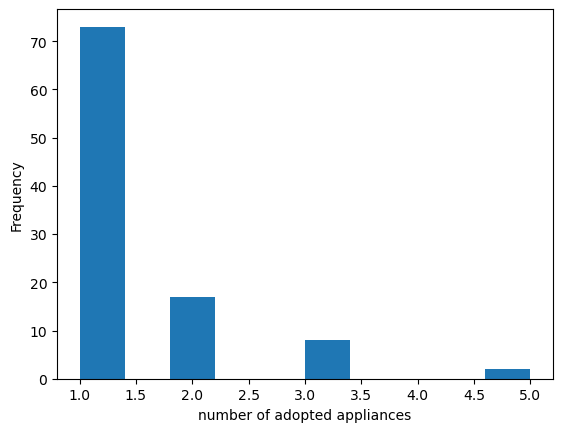

In [ ]:
adoption_counts = df["agent_id"].value_counts()

heaviest_adopters = adoption_counts.iloc[:3].index.to_list()
ax = adoption_counts.reset_index(drop=True).plot(kind="hist")
ax.set_xlabel("number of adopted appliances")

In [ ]:
df["tpb_tech"].value_counts(), df["mcda_tech"].value_counts()

(tpb_tech
 Gas furnace         11
 Heat pump            9
 Electric furnace     6
 Oil furnace          5
 Name: count, dtype: int64,
 mcda_tech
 Gas furnace         62
 Heat pump           44
 Electric furnace     4
 Name: count, dtype: int64)

# Improve_io
io needs improvment. data reading and writing should be formalized to split creation and analysis phase for better automation

In [1]:
from mesa.batchrunner import batch_run
from components.model import TechnologyAdoptionModel

In [2]:
province = "Canada"  # "Alberta", "Ontario", ...
batch_parameters = {
    "N": [100],
    "province": [province],
    "random_seed": range(20, 28),
    # "n_segregation_steps": [15],
    "interact": [True],
}

result = batch_run(
    TechnologyAdoptionModel,
    batch_parameters,
    number_processes=None,
    data_collection_period=1,
    max_steps=80,
)

100%|██████████| 8/8 [00:07<00:00,  1.05it/s]


SyntaxError: invalid syntax (1280232322.py, line 6)

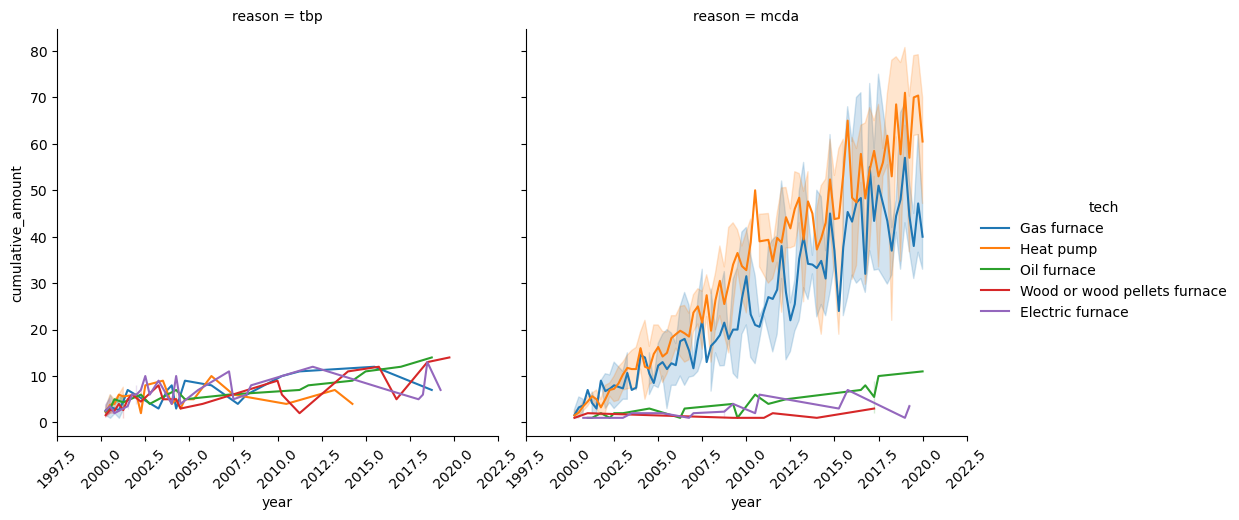

In [14]:
import seaborn as sns
from components.model import TechnologyAdoptionModel
from config import START_YEAR, STEPS_PER_YEAR, PROVINCE


path = Path("results/UNIQUE_MODEL_NAME")
b_result = Batchresult(path, result, batch_parameters)
# ax = b_result.attitudes_fig
# ax = b_result.viz_adoption
ax = b_result.adoption_details_fig
ax


# improve performance

In [23]:
from data.canada.timeseries import necessary_heating_capacity_for_province
from data.canada import get_fuel_price
from components.technologies import merge_heating_techs_with_share, HeatingTechnology
from numba import njit


@njit
def _cost_calculations(heat_demand, efficiencies, specific_fuel_costs,  appliance_size, specific_investment_costs, specific_fom_costs, lifetime):
    
    annuity_factors = discount_rate / (
            1 - (1 + discount_rate) ** -lifetime
        )
    fuel_cost = heat_demand / efficiencies * specific_fuel_costs
    annuity_payment = appliance_size * annuity_factors * specific_investment_costs
    fom_cost = appliance_size * specific_fom_costs
    return fuel_cost + annuity_payment + fom_cost 


def annual_cost_from_df_numba(heating_demand, tech_df):

    efficiencies = tech_df["efficiency"].values
    specific_fuel_cost = tech_df["specific_fuel_cost"].values 
    
    size = necessary_heating_capacity_for_province(heating_demand)
    heat_techs_df["annuity_factor"].values * heat_techs_df["specific_cost"].values
    # annuity_factors = heat_techs_df["annuity_factor"].values 
    specific_cost = heat_techs_df["specific_cost"].values 
    specific_fom_cost = tech_df["specific_fom_cost"].astype(np.float32).values
    lifetime = tech_df["lifetime"].values
    

    costs = _cost_calculations(heating_demand, efficiencies, specific_fuel_cost, size, specific_cost, specific_fom_cost, lifetime)
    return costs

def annual_cost_from_df_fast(heating_demand, tech_df):

    # efficiencies = tech_df["efficiency"].values
    # specific_fuel_cost = tech_df["specific_fuel_cost"].values 
    # fuel_cost = heating_demand / efficiencies * specific_fuel_cost 
    efficiencies = tech_df["efficiency"].values
    specific_fuel_cost = tech_df["specific_fuel_cost"].values 
    fuel_cost = heating_demand / efficiencies * specific_fuel_cost 
    # annuity_factor = discount_rate / (
    #         1 - (1 + discount_rate) ** -tech_df["lifetime"].values
    #     )
    annuity_factor = tech_df["annuity_factor"].values
    size = necessary_heating_capacity_for_province(heating_demand)
    annuity = annuity_factor * heat_techs_df["specific_cost"].values
    annuity_and_fom = size * np.array([annuity, tech_df["specific_fom_cost"].astype(float)])
    return fuel_cost + annuity_and_fom.sum(axis=0)



year = 2000 # ... 2050
province = "Alberta" # ... "British Columbia"

heat_techs_df = merge_heating_techs_with_share(year, province)

discount_rate = 0.07
heat_techs_df["annuity_factor"] = discount_rate / (
    1 - (1 + discount_rate) ** -heat_techs_df["lifetime"]
)

prices = []
for fuel in heat_techs_df["fuel"]:
    fuel_price = get_fuel_price(fuel, province, year)
    prices.append(fuel_price)
heat_techs_df["specific_fuel_cost"] = prices

heat_demand = 20e5 # kwh

annuity_cost_numba = annual_cost_from_df_numba(heat_demand, heat_techs_df)
annuity_cost_fast = annual_cost_from_df_fast(heat_demand, heat_techs_df)
annuity_cost_old = HeatingTechnology.annual_cost_from_df(heat_demand, heat_techs_df)

print(
    f"{annuity_cost_fast=}",
f"\n {annuity_cost_old=}",
f"\n {annuity_cost_numba=}",
)

%timeit -n 1000 annual_cost_from_df_fast(heat_demand, heat_techs_df)

%timeit -n 1000 annual_cost_from_df_numba(heat_demand, heat_techs_df)

%timeit -n 1000 HeatingTechnology.annual_cost_from_df(heat_demand, heat_techs_df)

annuity_cost_fast=array([ 175307.18167441,   54025.07912532,  137058.20479387,
        131200.44324238, 1054820.66278006]) 
 annuity_cost_old=Electric furnace                1.702317e+05
Gas furnace                     4.081651e+04
Heat pump                       7.451758e+04
Oil furnace                     1.222473e+05
Wood or wood pellets furnace    1.024820e+06
dtype: float64 
 annuity_cost_numba=array([ 175307.18172518,   54025.07902378,  137058.20514923,
        131200.44339467, 1054820.66262776])
87.2 µs ± 16.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
95.5 µs ± 15.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
551 µs ± 55 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [1]:
551/87.2

6.318807339449541